# **Imports**

In [1]:
# Common
import os
import cv2 as cv
import pandas as pd
from tqdm import tqdm

# data 
import numpy as np 
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt

# Model
import keras 
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import MeanIoU


# **Data**

In [2]:
images = []
mask = []

image_path = 'Water Bodies Dataset/Images/'
mask_path = 'Water Bodies Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
    print('Image and Mask are corretly Placed!!')

Image and Mask are corretly Placed!!


In [3]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = img_to_array(load_img(path)).astype('float')/255.
    img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = img_to_array(load_img(path)).astype('float')/255.
    mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
    masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:54<00:00, 51.81it/s] 


In [4]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None: plt.title(title)
    plt.axis('off')

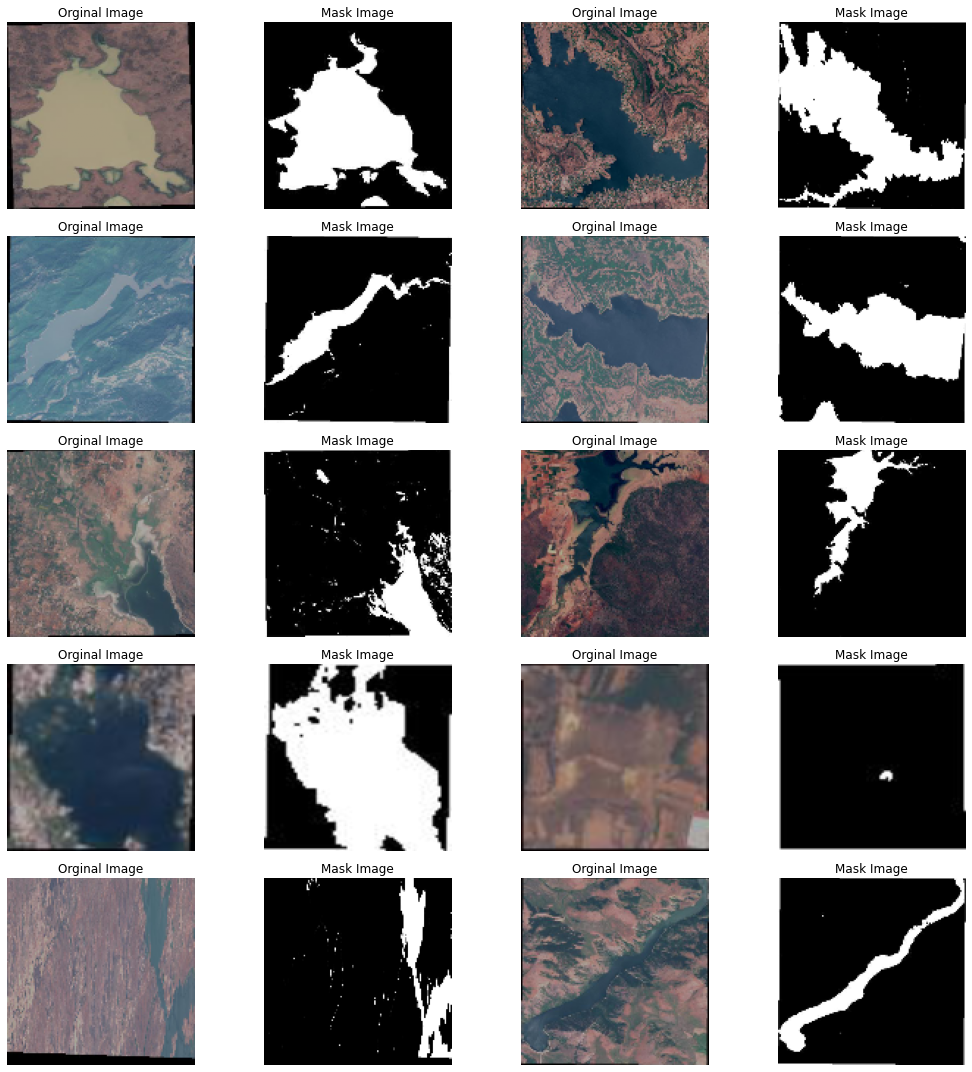

In [5]:
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(5,4,i)
    if i%2!=0:
        id = np.random.randint(len(images))
        show_image(images[id], title="Orginal Image")
    elif i%2==0:
        show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')
plt.tight_layout()
plt.show()

# **U-Net**

In [6]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [7]:
# Contraction 
class EncoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, pooling=True):
        super(EncoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        if self.pooling: 
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

# Expansion
class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate):
        super(DecoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
    def call(self, inputs):
        X, short_X = inputs
        ct = self.up(X)
        c_ = concatenate([ct, short_X])
        x = self.net(c_)
        return x
 

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate
        }

# Callback 
class ShowProgress(keras.callbacks.Callback):
    def __init__(self, SIZE):
        self.SIZE = SIZE
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = self.model.predict(real_img)[0]
        mask = masks[id]

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        show_image(real_img[0], title="Orginal Image")

        plt.subplot(1,3,2)
        show_image(pred_mask, title="Predicted Mask", cmap='gray')

        plt.subplot(1,3,3)
        show_image(mask, title="Orginal Mask", cmap='gray')


        plt.tight_layout()
        plt.show()

2022-09-03 05:10:25.704198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 05:10:25.849873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 05:10:25.851002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 05:10:25.853079: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2022-09-03 05:10:32.652666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 13s 64ms/step - loss: 0.5829 - accuracy: 0.5462 - IoU: 0.3803 - val_loss: 0.4617 - val_accuracy: 0.6589 - val_IoU: 0.3962


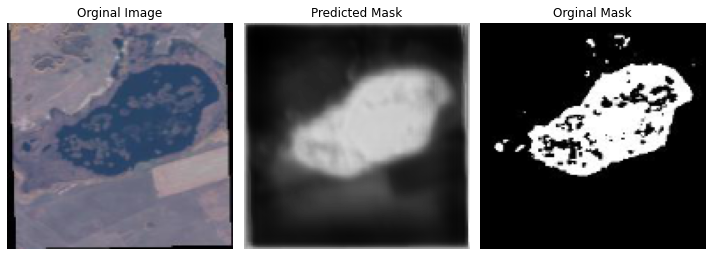

Epoch 2/20
72/72 [==============================] - 3s 46ms/step - loss: 0.4395 - accuracy: 0.6686 - IoU: 0.4019 - val_loss: 0.3792 - val_accuracy: 0.6848 - val_IoU: 0.3962


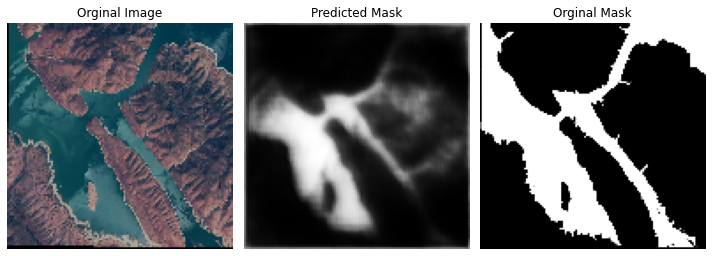

Epoch 3/20
72/72 [==============================] - 3s 47ms/step - loss: 0.3965 - accuracy: 0.6899 - IoU: 0.4095 - val_loss: 0.3329 - val_accuracy: 0.7073 - val_IoU: 0.4181


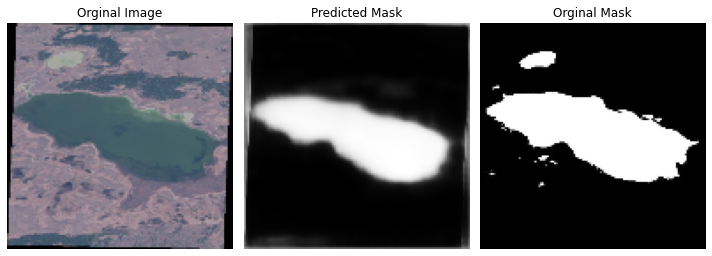

Epoch 4/20
72/72 [==============================] - 3s 46ms/step - loss: 0.3648 - accuracy: 0.7006 - IoU: 0.3988 - val_loss: 0.3342 - val_accuracy: 0.7045 - val_IoU: 0.3962


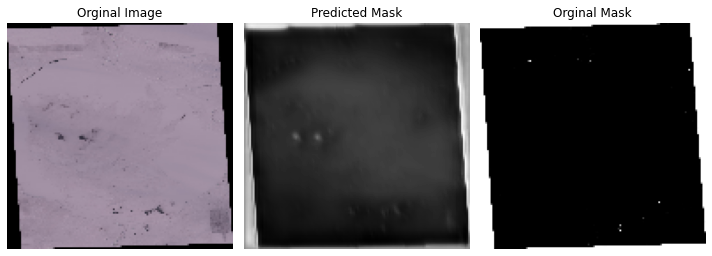

Epoch 5/20
72/72 [==============================] - 3s 47ms/step - loss: 0.3394 - accuracy: 0.7102 - IoU: 0.4006 - val_loss: 0.3102 - val_accuracy: 0.7174 - val_IoU: 0.3962


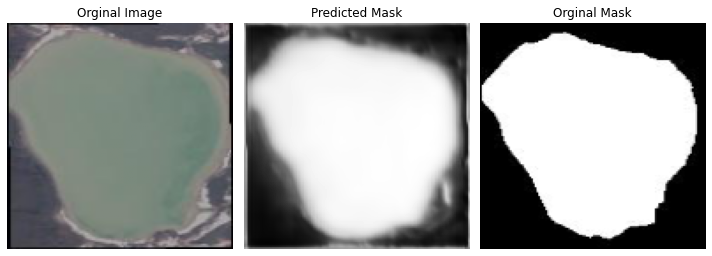

Epoch 6/20
72/72 [==============================] - 3s 47ms/step - loss: 0.3375 - accuracy: 0.7119 - IoU: 0.3997 - val_loss: 0.3183 - val_accuracy: 0.7169 - val_IoU: 0.3962


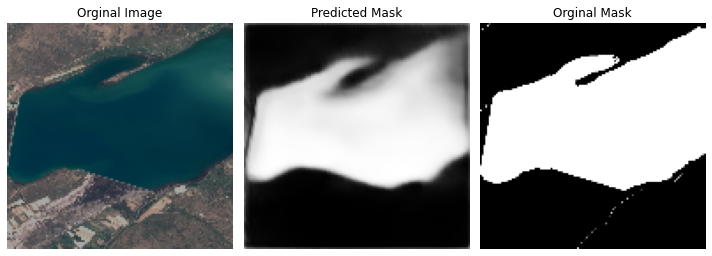

Epoch 7/20
72/72 [==============================] - 3s 46ms/step - loss: 0.3287 - accuracy: 0.7143 - IoU: 0.4098 - val_loss: 0.2809 - val_accuracy: 0.7265 - val_IoU: 0.4195


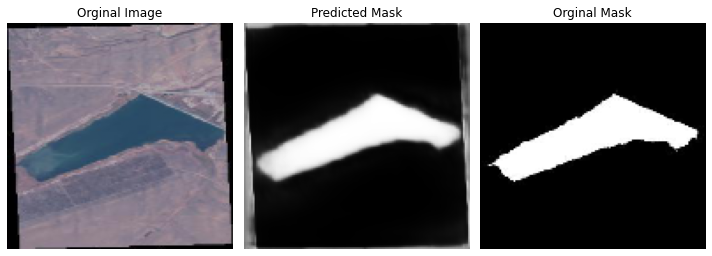

Epoch 8/20
72/72 [==============================] - 3s 46ms/step - loss: 0.3101 - accuracy: 0.7214 - IoU: 0.4026 - val_loss: 0.2787 - val_accuracy: 0.7258 - val_IoU: 0.4018


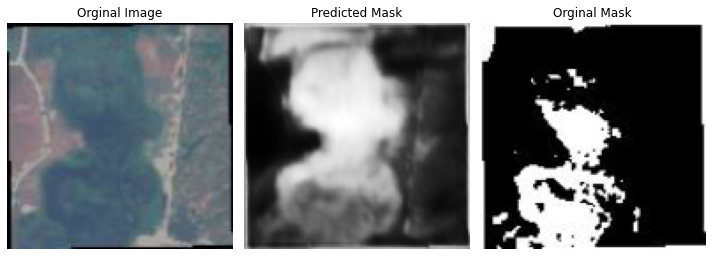

Epoch 9/20
72/72 [==============================] - 3s 46ms/step - loss: 0.3034 - accuracy: 0.7231 - IoU: 0.4066 - val_loss: 0.2784 - val_accuracy: 0.7278 - val_IoU: 0.4010


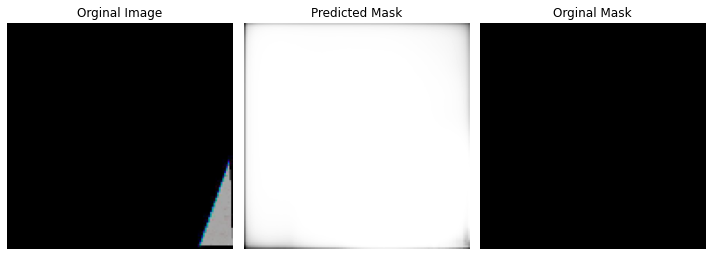

Epoch 10/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2984 - accuracy: 0.7276 - IoU: 0.4292 - val_loss: 0.3157 - val_accuracy: 0.7204 - val_IoU: 0.3962


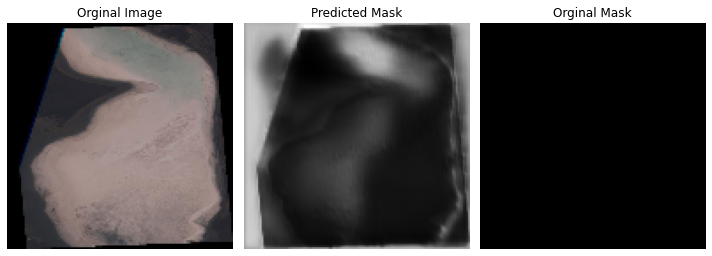

Epoch 11/20
72/72 [==============================] - 3s 46ms/step - loss: 0.3162 - accuracy: 0.7196 - IoU: 0.3856 - val_loss: 0.2675 - val_accuracy: 0.7300 - val_IoU: 0.4041


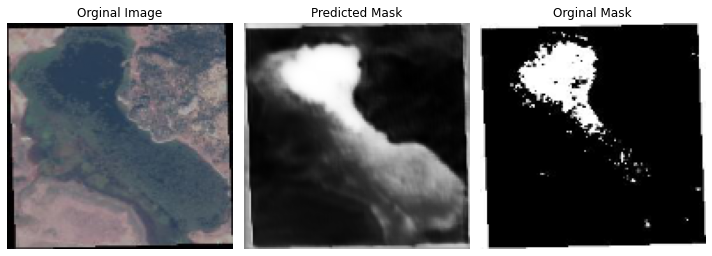

Epoch 12/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2815 - accuracy: 0.7305 - IoU: 0.4084 - val_loss: 0.2644 - val_accuracy: 0.7288 - val_IoU: 0.4079


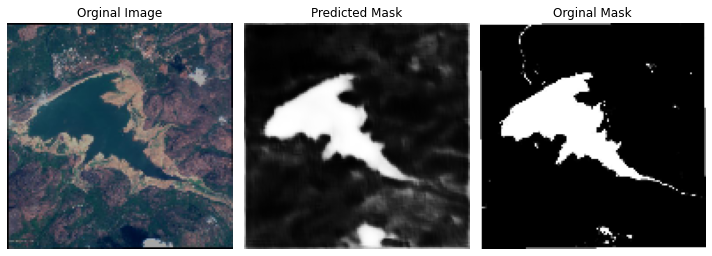

Epoch 13/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2868 - accuracy: 0.7291 - IoU: 0.4046 - val_loss: 0.2820 - val_accuracy: 0.7234 - val_IoU: 0.3964


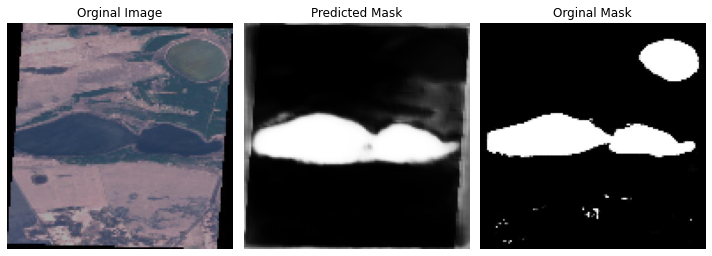

Epoch 14/20
72/72 [==============================] - 3s 46ms/step - loss: 0.3062 - accuracy: 0.7224 - IoU: 0.4071 - val_loss: 0.2795 - val_accuracy: 0.7279 - val_IoU: 0.4098


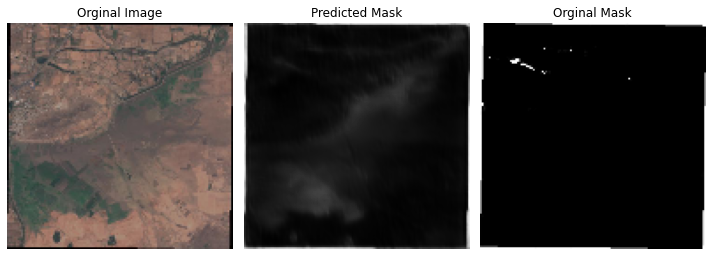

Epoch 15/20
72/72 [==============================] - 3s 47ms/step - loss: 0.2707 - accuracy: 0.7346 - IoU: 0.4005 - val_loss: 0.2593 - val_accuracy: 0.7321 - val_IoU: 0.4102


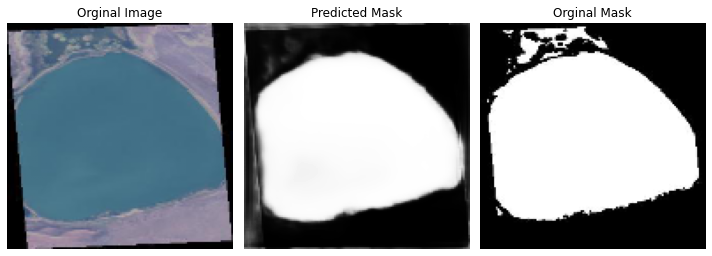

Epoch 16/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2584 - accuracy: 0.7388 - IoU: 0.3977 - val_loss: 0.2443 - val_accuracy: 0.7386 - val_IoU: 0.4111


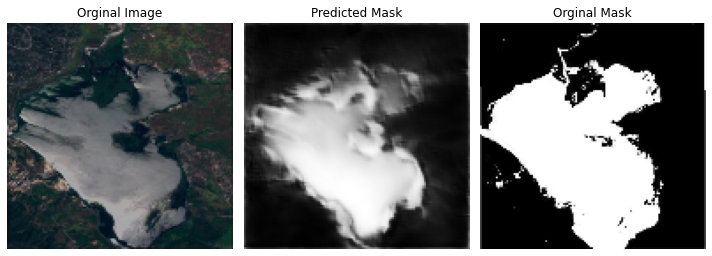

Epoch 17/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2631 - accuracy: 0.7367 - IoU: 0.4040 - val_loss: 0.2524 - val_accuracy: 0.7360 - val_IoU: 0.4163


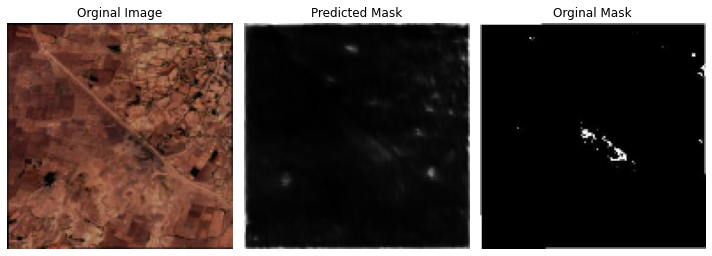

Epoch 18/20
72/72 [==============================] - 3s 47ms/step - loss: 0.2489 - accuracy: 0.7408 - IoU: 0.4359 - val_loss: 0.2385 - val_accuracy: 0.7376 - val_IoU: 0.4339


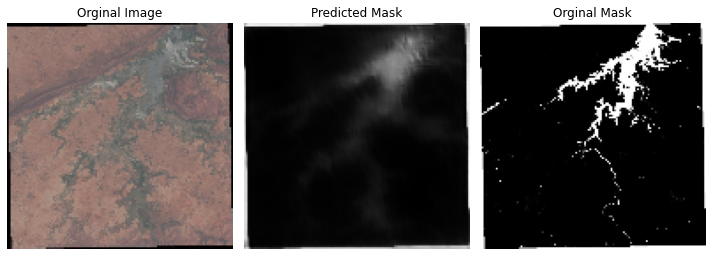

Epoch 19/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2406 - accuracy: 0.7436 - IoU: 0.4436 - val_loss: 0.2320 - val_accuracy: 0.7405 - val_IoU: 0.4482


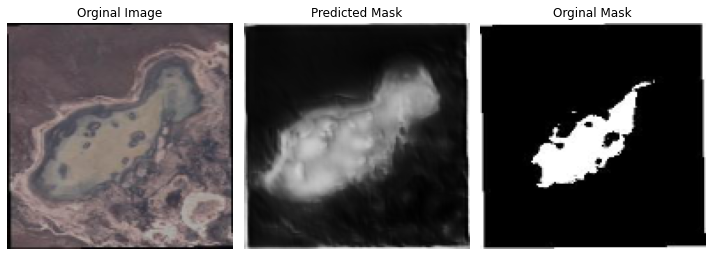

Epoch 20/20
72/72 [==============================] - 3s 46ms/step - loss: 0.2312 - accuracy: 0.7473 - IoU: 0.4569 - val_loss: 0.2372 - val_accuracy: 0.7394 - val_IoU: 0.4188


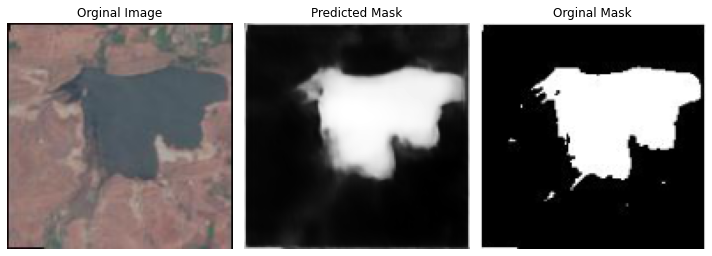

In [8]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1,c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1)([d3,c1])

# Outputs 
outputs = Conv2D(1,1,activation='sigmoid')(d4)

# Model
unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

# Compiling
unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),# The Model will train quickly use it if you want it, For model Comparision I am not using it
    ModelCheckpoint("UNet.h5", save_best_only=True),
    ShowProgress( SIZE=SIZE)
]

# Training
unet_history = unet.fit(
    X,y,
    epochs=20,
    callbacks=callbacks,
    validation_split=0.1
)

**UNet Worked fast** but we can improve the performance using **Attention gate**.

# **Attention UNet**

The base Model structure of UNet is not changed by a **Short Attention Module** is inserted in the **Skip Connections** $:$

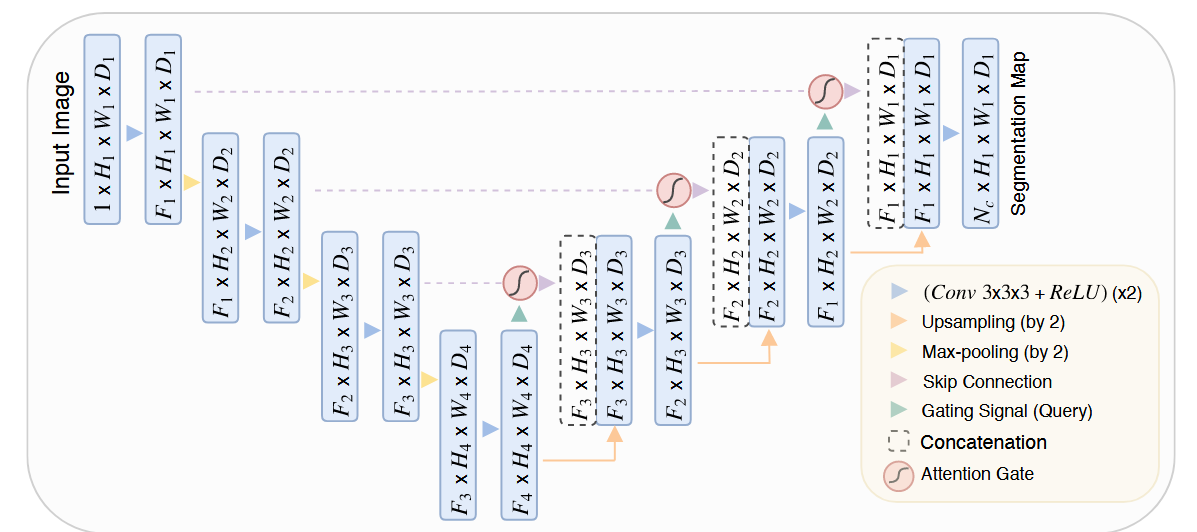

This added **Attention Module/Gate** has the **Following Architecture** $:$

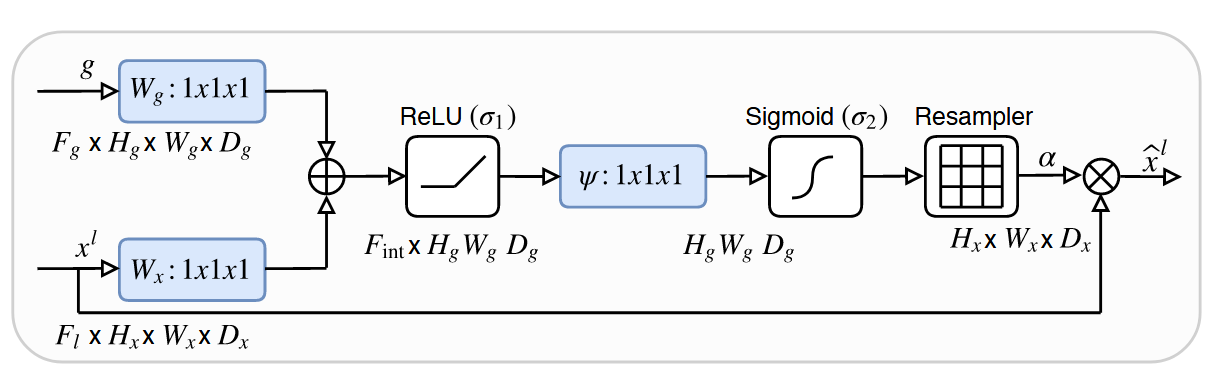

Where,
* $x$ are the **Skip Inputs**
* $g$ is the Input from **Previous Decoder**



This is a **Soft Attention Module** and it is self-explanatory for code look below :

---
$Bonus :$ [ViT](https://www.kaggle.com/code/utkarshsaxenadn/vit-vision-transformer-in-keras-tensorflow) is an example of a Hard Attention Model.

In [9]:
# Expansion
class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate):
        super(DecoderBlock,self).__init__()
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.c1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')

    def call(self, inputs):
        X, short_X = inputs
        ct = self.up(X)
        c_ = concatenate([ct, short_X])
        x = self.c1(c_)
        y = self.c2(x)
        return y

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
        }

In [10]:
class AttentionChannel(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionChannel, self).__init__(**kwargs)
        self.filters = filters
        
        self.C1 = Conv2D(filters, kernel_size=1, strides=1, padding='same', activation=None)
        self.C2 = Conv2D(filters, kernel_size=1, strides=2, padding='same', activation=None)
        self.relu = keras.activations.ReLU()
        self.add = keras.layers.Add()
        self.C3 = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')
        self.up = keras.layers.UpSampling2D()
        self.mul = keras.layers.Multiply()
        self.BN = BatchNormalization()
                
    def call(self, X):
        org_x, skip_g = X
        g = self.C1(org_x)
        x = self.C2(skip_g)
        x = self.add([g,x])
        x = self.C3(x)
        x = self.up(x)
        x = self.mul([x,skip_g])
        x = self.BN(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        base_config.update({
            "filters":self.filters
        })
        return base_config

In [11]:
#  Input
input_shape = (SIZE, SIZE, 3)
input_layer = Input(shape=input_shape)

# Encoder
p1, c1 = EncoderBlock(32,0.1)(input_layer)
p2, c2 = EncoderBlock(64,0.1)(p1)
p3, c3 = EncoderBlock(128,0.2)(p2)
p4, c4 = EncoderBlock(256,0.2)(p3)

# Latent Representation
c5 = EncoderBlock(512, 0.3, pooling=False)(p4)

# Attention-Decoder
a1 = AttentionChannel(256)([c5, c4])
d1 = DecoderBlock(256,0.2)([c5, a1])

a2 = AttentionChannel(128)([d1, c3])
d2 = DecoderBlock(128,0.2)([d1, a2])

a3 = AttentionChannel(64)([d2, c2])
d3 = DecoderBlock(64,0.1)([d2, a3])

a4 = AttentionChannel(32)([d3, c1])
d4 = DecoderBlock(32,0.1)([d3, a4])
# outputs
output_layer = Conv2D(1,kernel_size=1, strides=1, padding='same', activation='sigmoid')(d4)

Epoch 1/20
72/72 [==============================] - 10s 111ms/step - loss: 0.3271 - accuracy: 0.7101 - IoU: 0.4276 - val_loss: 0.5322 - val_accuracy: 0.6549 - val_IoU: 0.4077


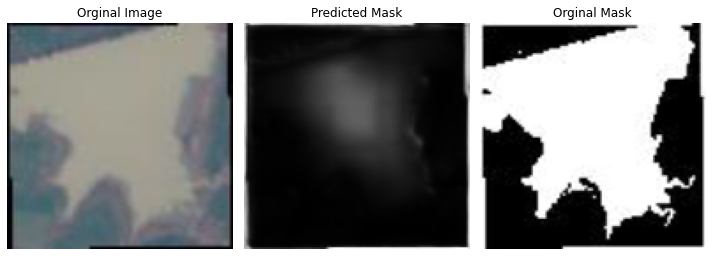

Epoch 2/20
72/72 [==============================] - 7s 100ms/step - loss: 0.2988 - accuracy: 0.7213 - IoU: 0.4430 - val_loss: 0.3502 - val_accuracy: 0.7063 - val_IoU: 0.4242


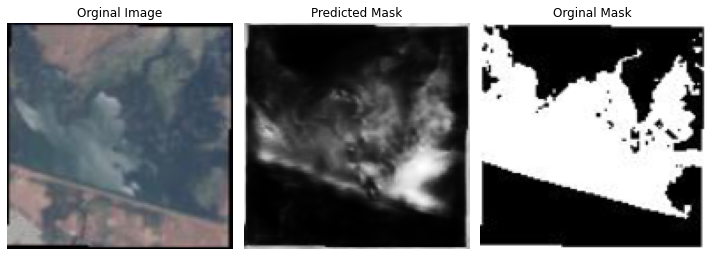

Epoch 3/20
72/72 [==============================] - 7s 100ms/step - loss: 0.3006 - accuracy: 0.7224 - IoU: 0.4562 - val_loss: 0.3548 - val_accuracy: 0.6849 - val_IoU: 0.3973


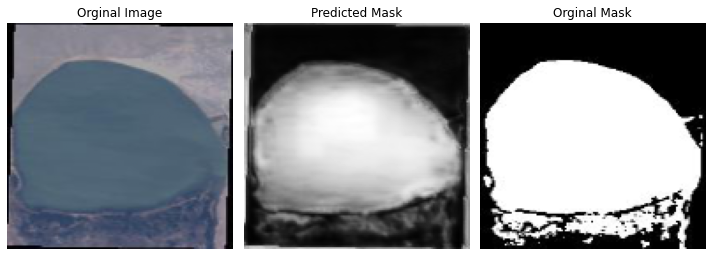

Epoch 4/20
72/72 [==============================] - 7s 100ms/step - loss: 0.3303 - accuracy: 0.7075 - IoU: 0.3880 - val_loss: 0.2918 - val_accuracy: 0.7220 - val_IoU: 0.4061


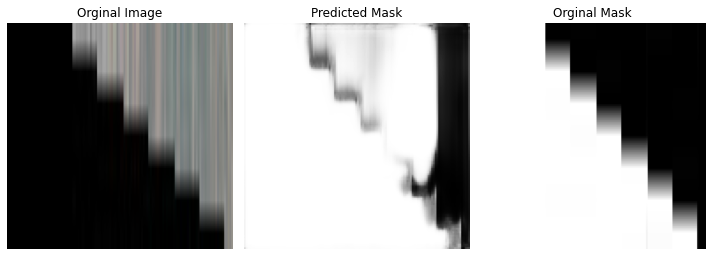

Epoch 5/20
72/72 [==============================] - 7s 101ms/step - loss: 0.3101 - accuracy: 0.7162 - IoU: 0.4037 - val_loss: 0.2748 - val_accuracy: 0.7244 - val_IoU: 0.4175


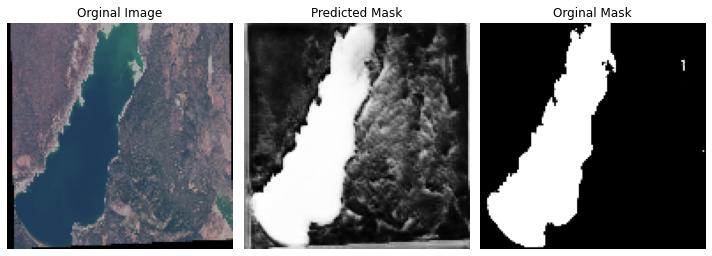

Epoch 6/20
72/72 [==============================] - 7s 100ms/step - loss: 0.3084 - accuracy: 0.7213 - IoU: 0.4228 - val_loss: 0.2921 - val_accuracy: 0.7032 - val_IoU: 0.4144


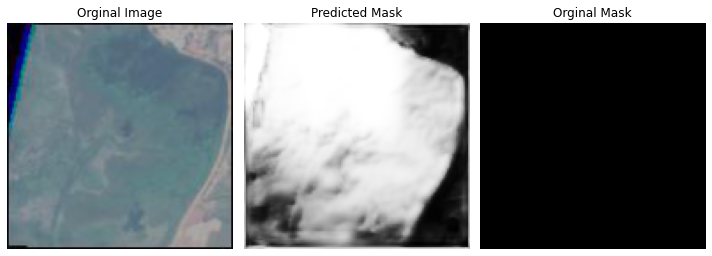

Epoch 7/20
72/72 [==============================] - 7s 100ms/step - loss: 0.2988 - accuracy: 0.7203 - IoU: 0.4411 - val_loss: 0.3672 - val_accuracy: 0.6867 - val_IoU: 0.4272


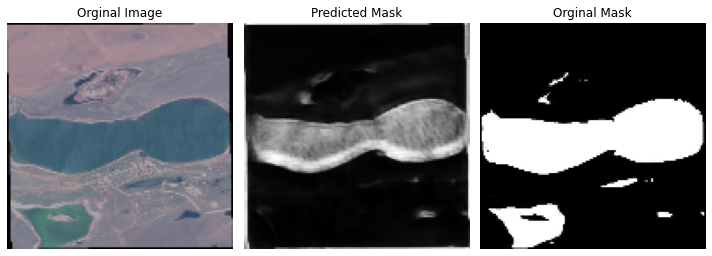

Epoch 8/20
72/72 [==============================] - 7s 101ms/step - loss: 0.2767 - accuracy: 0.7287 - IoU: 0.4469 - val_loss: 0.2368 - val_accuracy: 0.7392 - val_IoU: 0.4257


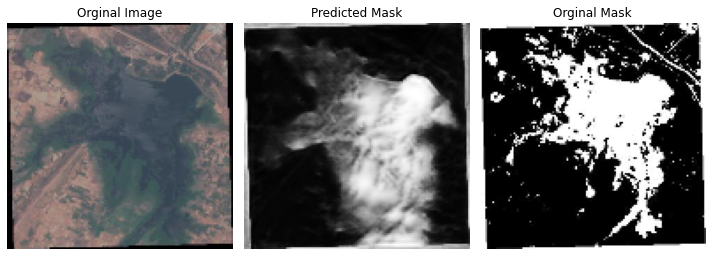

Epoch 9/20
72/72 [==============================] - 7s 101ms/step - loss: 0.2758 - accuracy: 0.7304 - IoU: 0.4571 - val_loss: 0.2558 - val_accuracy: 0.7305 - val_IoU: 0.4323


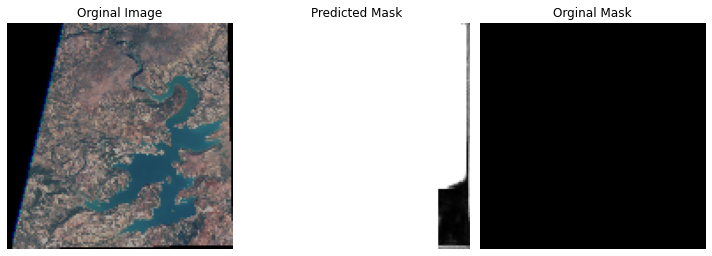

Epoch 10/20
72/72 [==============================] - 7s 101ms/step - loss: 0.2816 - accuracy: 0.7272 - IoU: 0.4310 - val_loss: 0.3514 - val_accuracy: 0.6996 - val_IoU: 0.3973


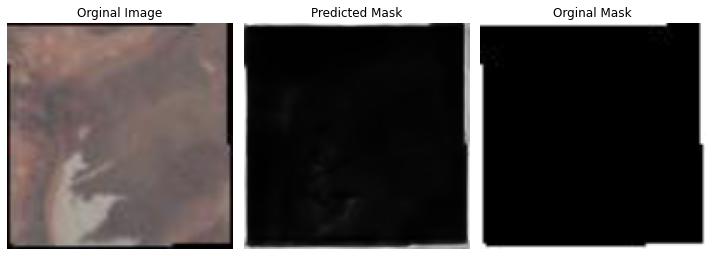

Epoch 11/20
72/72 [==============================] - 7s 100ms/step - loss: 0.2749 - accuracy: 0.7288 - IoU: 0.4164 - val_loss: 0.2563 - val_accuracy: 0.7280 - val_IoU: 0.4161


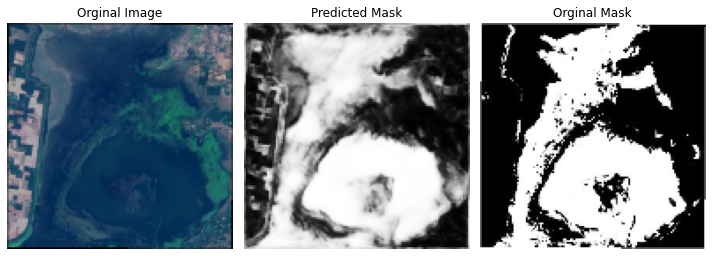

In [15]:
# Model
attention_unet = keras.models.Model(
    inputs=[input_layer],
    outputs=[output_layer],
)

# Compiling
attention_unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),# The Model will train quickly use it if you want it, For model Comparision I am not using it
    ModelCheckpoint("AttentionUNet.h5", save_best_only=True),
    ShowProgress(SIZE=SIZE)
]

# Training
attention_history = attention_unet.fit(
    X,y,
    epochs=20,
    callbacks=callbacks,
    validation_split=0.1
)

Because the **Spatial Information** is shared through the **Skip Connections** and **Attention Model** Initialy pays attention to everything you can see that the Model was able to **keep the Spatial Information** till the **output layer**. This can be a good thing with works like **Lanscape Colorizer**. You can clearly Notice that the **Mask Predictions by Attention UNet are much clear.**

# **Model Comparision**

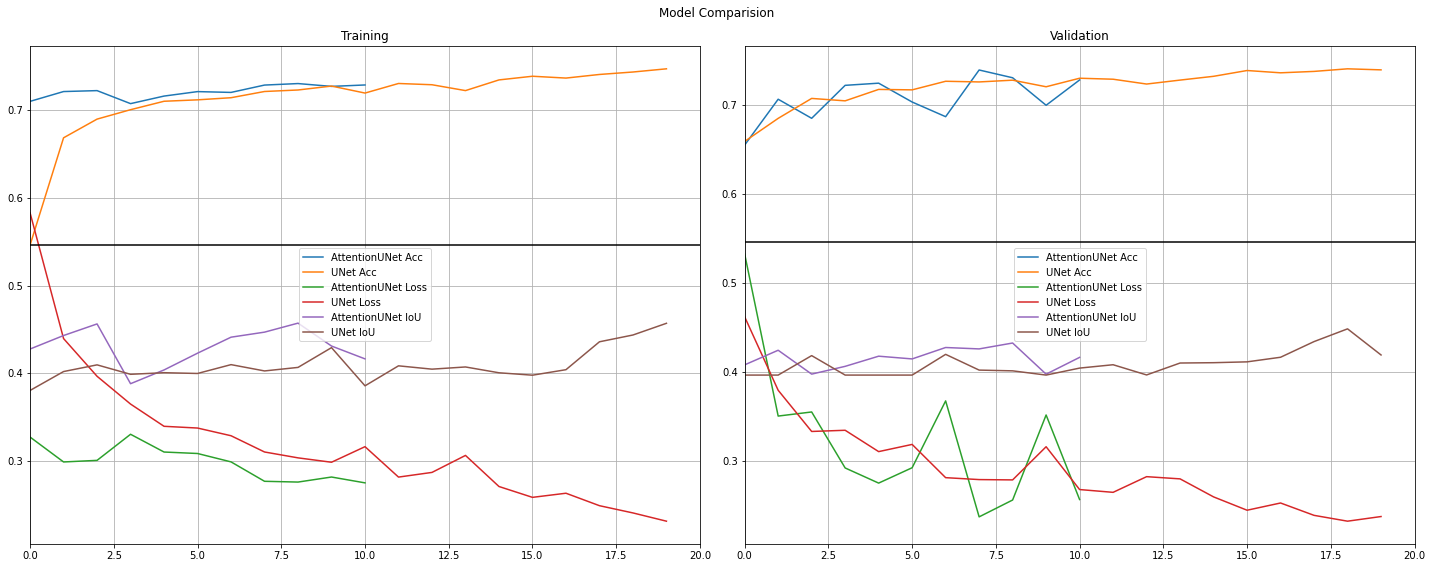

In [16]:
# learning Curves
attention_train_loss, attention_train_acc, attention_train_IoU, attention_valid_loss, attention_valid_acc, attention_valid_IoU  = attention_history.history.values()
unet_train_loss, unet_train_acc, unet_train_IoU, unet_valid_loss, unet_valid_acc, unet_valid_IoU = unet_history.history.values()

# Viz
plt.figure(figsize=(20,8))
plt.suptitle("Model Comparision")

plt.subplot(1,2,1)

plt.title("Training")
plt.plot(attention_train_acc, label="AttentionUNet Acc")
plt.plot(unet_train_acc, label="UNet Acc")

plt.plot(attention_train_loss, label="AttentionUNet Loss")
plt.plot(unet_train_loss, label="UNet Loss")

plt.plot(attention_train_IoU, label="AttentionUNet IoU")
plt.plot(unet_train_IoU, label="UNet IoU")
plt.axhline(min(attention_train_acc[0], unet_train_acc[0]), color='k')
plt.xlim([0,20])

plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation")
plt.plot(attention_valid_acc, label="AttentionUNet Acc")
plt.plot(unet_valid_acc, label="UNet Acc")

plt.plot(attention_valid_loss, label="AttentionUNet Loss")
plt.plot(unet_valid_loss, label="UNet Loss")

plt.plot(attention_valid_IoU, label="AttentionUNet IoU")
plt.plot(unet_valid_IoU, label="UNet IoU")
plt.axhline(min(attention_train_acc[0], unet_train_acc[0]), color='k')
plt.xlim([0,20])

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

We can clearly spot the difference, the loss is reduced that means the **Reconstruction has Improved** and in case of **Attention UNet** the **loss is lower** than the **Normal UNet**. Keep in mind that **UNet is best suited for Multi CLass Segmentationa and for Binary Class Segmentation SegNet works great.**

---
Let me know your suggestion, they help me to Improve.
**Thanks !!**